# Film Junky Union Review Analysis using ML:

### NOTE: ###
**I could not install the extension for Intel's GPU for Torch and as such could not run the BERT portion of my project on my local PC instead I had to use Google Colab for access to a GPU compatible with torch 'cuda'. This current notebook is only a copy of my colab notebook.**

**Here's a link to the Colab Notebook I worked on that has all the outputs from my code**
https://colab.research.google.com/drive/1ieHZcyKJB5AFtj6L6L5kYCrV_rRTTDTm?usp=sharing

## Introduction and Goals: ##

**Introduction:**

The goal of this analysis is to develop and create and develop a model capable of processing text (in this case movie reviews) and interpreting and classifying it appropriately in terms of positive and negative for Film Junky Union for an effective filtering and categorisation system for movie reviews.

**Goals:**

The project outline is as follows:
- Data loading and preperation, getting an overall look at the data and cheking missing/duplicate values and implement any necessary preprocessing.
- Perform an exploratory data analysis, look at the overall distribution of reviews per movie (as in how many reviews per movie) and how the amount of movies has increased drastically since film became a popular artistic medium. Look at the distribution of ratings (1-10) and the distribution of polarities (positive and negative) for all reviews then draw conclusions.
- Train various models keeping the company goal of an F1 score >= 0.85 in mind. Will normalise the data in 2 seperate ways for the classification models (LogisticRegression, RandomForestClassifier and LGBMClassifier) using the NLTK and spaCy methods of lemmatization respectively. Then train BERT based models interpreting results using seperate classification models (LogisticRegression, LGBMClassifier)
- To round off model development will test each model against the test set and determine final f1 score thus determining the best performing model and the best recommendation for Film Junky Union.
- Additionally will test each model against some select reviews and see how well the perform individually. Then conclude findings for the analysis.

**NOTE:**
f1 score is the harmonic mean of precision and recall, balances both, high precision says there are few false positives (how many the model said were correct but weren't), high recall says there are few false negatives (how many the model said were wrong but weren't). If for e.g. the model predicts mostly negatives but misses real positives accuracy can look good but f1 reveals weakness.

### Data Loading and Prep: ###

In [1]:
#initialisation
import math
import nltk
import os
import re
import spacy
import torch
import transformers
from datasets import Dataset
from google.colab import drive
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import normalize, StandardScaler
from tqdm.auto import tqdm
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
os.environ["WANDB_DISABLED"] = "true"

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
!wget -O imdb_reviews.tsv "https://github.com/michaelms123/Film-Junky-Union-Analysis/raw/refs/heads/main/imdb_reviews%20(1).tsv"

--2025-11-11 00:58:08--  https://github.com/michaelms123/Film-Junky-Union-Analysis/raw/refs/heads/main/imdb_reviews%20(1).tsv
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/michaelms123/Film-Junky-Union-Analysis/refs/heads/main/imdb_reviews%20(1).tsv [following]
--2025-11-11 00:58:08--  https://media.githubusercontent.com/media/michaelms123/Film-Junky-Union-Analysis/refs/heads/main/imdb_reviews%20(1).tsv
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66445660 (63M) [text/plain]
Saving to: ‘imdb_reviews.tsv’

imdb_reviews.tsv    100%[===================>]  63.37M  19.4MB/s  

In [3]:
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [4]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [5]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [6]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,47329.0,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,25562.917323,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,83670.039163,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.0,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,827.0,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3197.0,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,13974.0,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1739448.0,10.000000,1.000000,12499.000000


In [7]:
df_reviews.isna().sum()

,0
tconst,0
title_type,0
primary_title,0
original_title,0
start_year,0
end_year,0
runtime_minutes,0
is_adult,0
genres,0
average_rating,2


In [8]:
df_reviews.duplicated().sum()

np.int64(0)

<div class="alert alert-success"; style="border-left: 7px solid green">
<b>✅ Reviewer's comment V1</b>
    
This part looks good.
</div>

### Data Loading and Prep Conclusions: ###
- Loaded the 'tsv' file (tab seperated values) the formatting for naming conventions (typically snake_case) is in order and doesn't require renaming or processing.
- The general info and description for the data shows that the datatypes for the columns are in order and won't need conversion.
- Check for missing/duplicate data reveals there are none and the dataset does not require further editing.

## Exploratory Data Analysis: ##

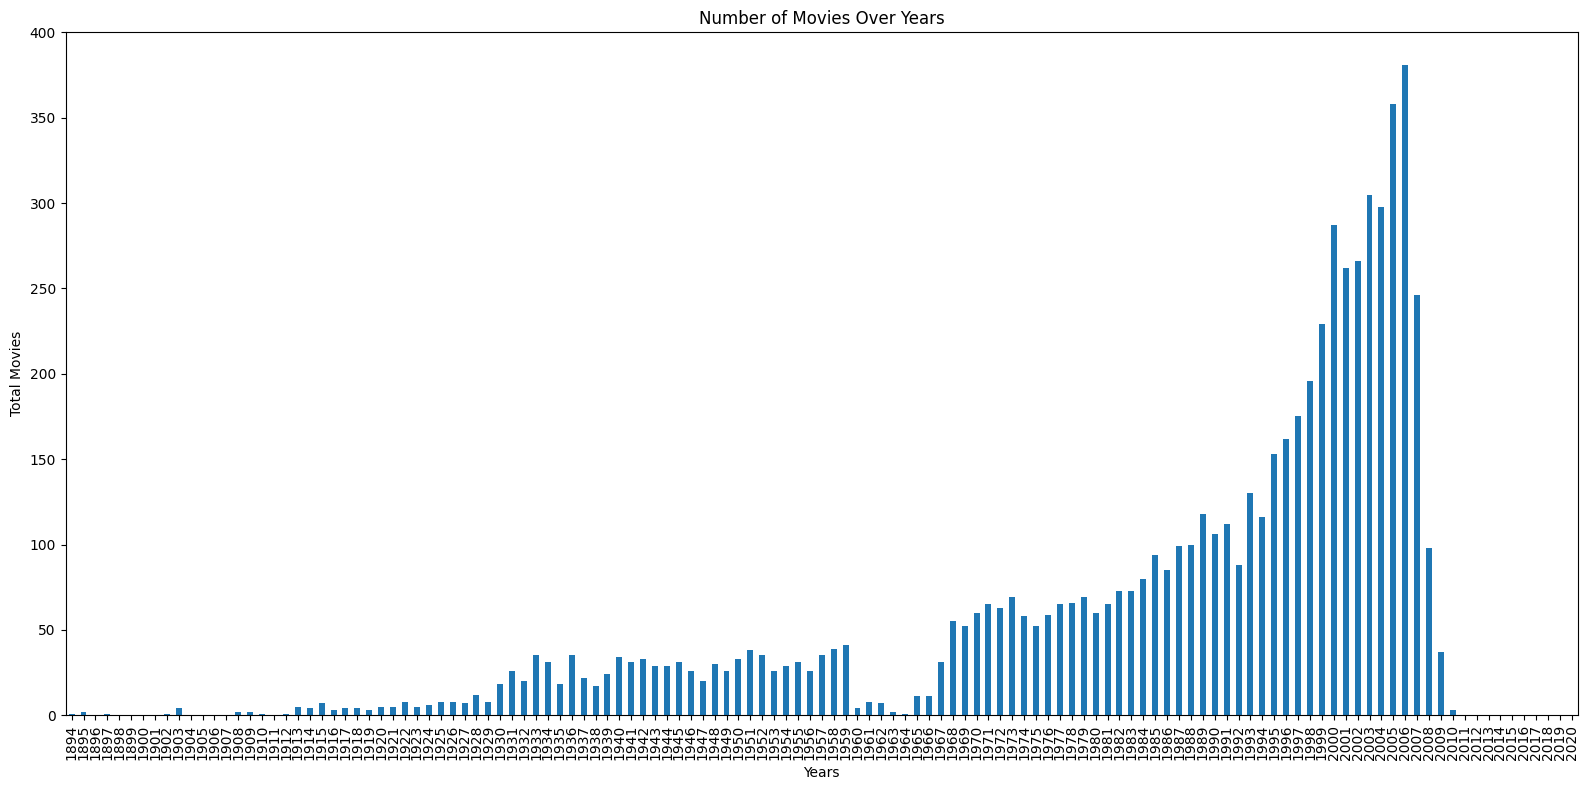

In [9]:
#creating a bar graph of all movies over the years
plt.figure(figsize=(16, 8))
total_movies_df = df_reviews[['tconst', 'start_year']].drop_duplicates()['start_year'].value_counts().sort_index()
total_movies_df = total_movies_df.reindex(index=np.arange(total_movies_df.index.min(), max(total_movies_df.index.max(), 2021))).fillna(0)
total_movies_df.plot(kind='bar')
plt.title('Number of Movies Over Years')
plt.xlabel('Years')
plt.ylabel('Total Movies')
plt.xticks(rotation=90)
plt.tight_layout()

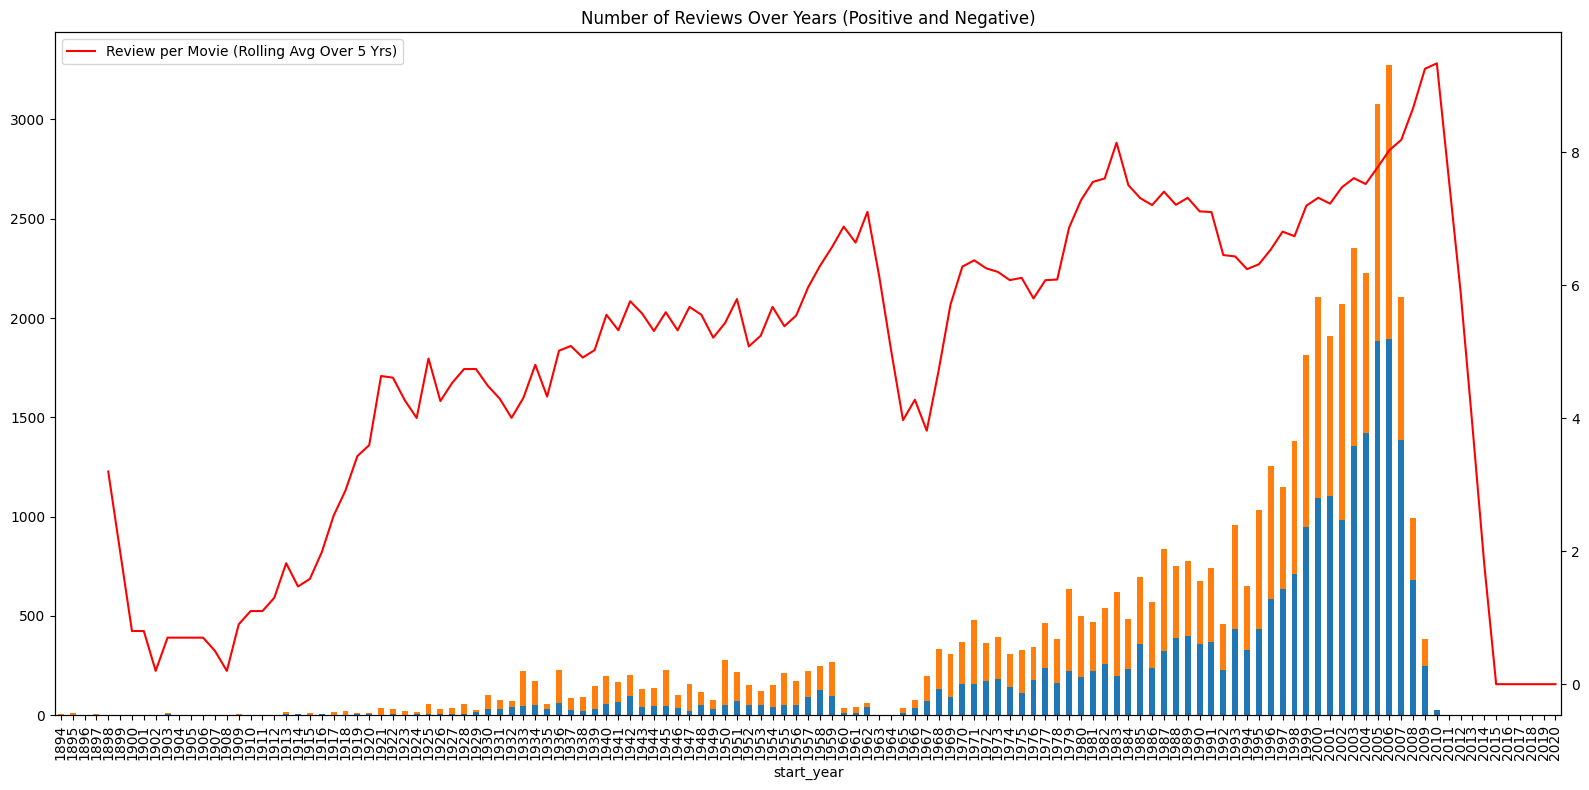

In [10]:
#creating bar graph that shows negative and positive reviews stacked and rolling average (every 5 yrs)
plt.figure(figsize=(16, 8))
total_reviews_df = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
total_reviews_df = total_reviews_df.reindex(index=np.arange(total_reviews_df.index.min(), max(total_reviews_df.index.max(), 2021))).fillna(0)

ax = total_reviews_df.plot(kind='bar', stacked=True, ax=plt.gca(), label='#reviews (neg, pos)')

total_reviews_df = total_reviews_df.reindex(index=np.arange(total_reviews_df.index.min(), max(total_reviews_df.index.max(), 2021))).fillna(0)
#average no. of reviews:
avg_reviews = (total_reviews_df.sum(axis=1).astype(float)/total_movies_df.replace(0, np.nan)).fillna(0)

#line graph that shows the rolling mean over 5 years
ax_2 = ax.twinx()
avg_reviews.reset_index(drop=True).rolling(5).mean().plot(color='red', label='Review per Movie (Rolling Avg Over 5 Yrs)', ax=ax_2)

lines, labels = ax_2.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')
ax.set_title('Number of Reviews Over Years (Positive and Negative)')
plt.tight_layout()

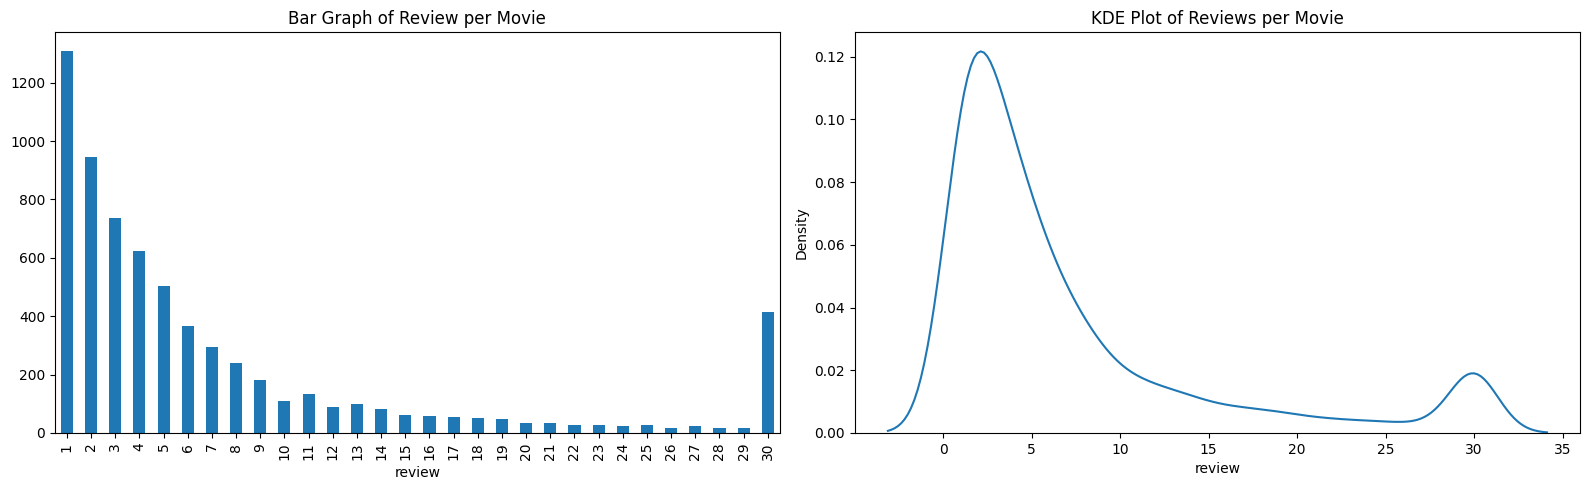

In [11]:
#bar graph/kde plot of reviews per movie
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
ax = axs[0]
reviews = df_reviews.groupby('tconst')['review'].count().value_counts().sort_index()
reviews.plot(kind='bar', ax=ax)
ax.set_title('Bar Graph of Review per Movie')

ax2 = axs[1]
reviews = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(reviews, ax=ax2)
ax2.set_title('KDE Plot of Reviews per Movie')

fig.tight_layout()

In [12]:
#checking the amount of positive to negative reviews
df_reviews['pos'].value_counts()

,count
pos,
0,23715
1,23616


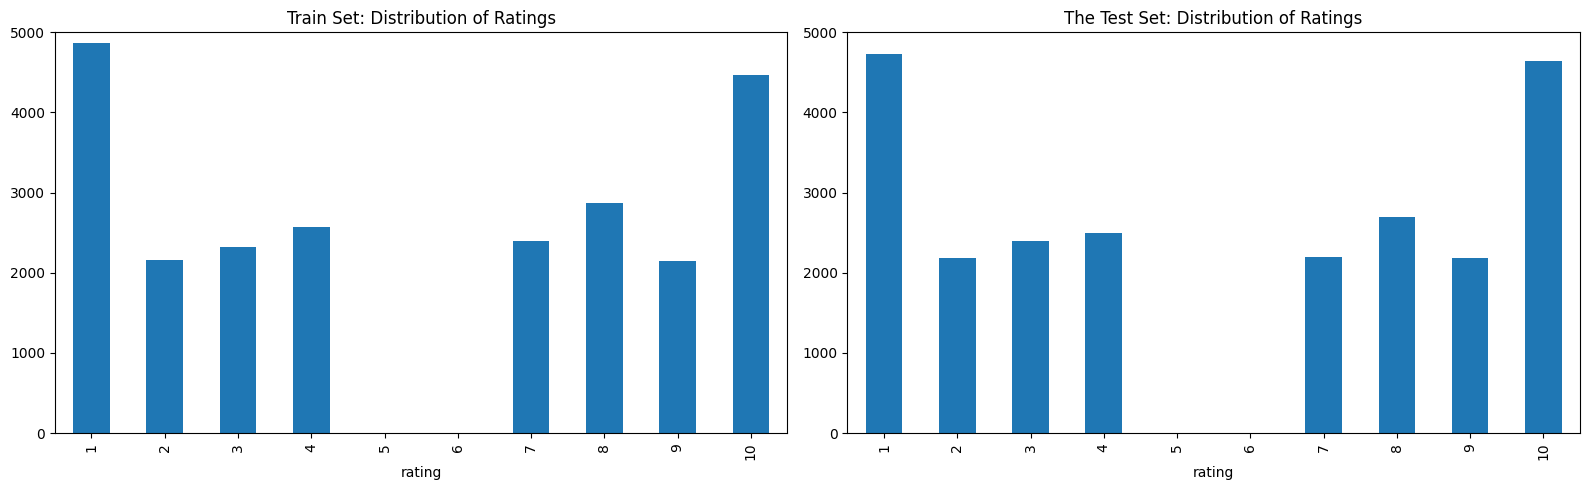

In [13]:
#bar graph showing the distribution of ratings (1-10) for both sets of data (training/test)
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
ratings_train = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
ratings_train = ratings_train.reindex(index=np.arange(min(ratings_train.index.min(), 1), max(ratings_train.index.max(), 11))).fillna(0)
ratings_train.plot(kind='bar', ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Train Set: Distribution of Ratings')

ax2 = axs[1]
ratings_test = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
ratings_test = ratings_test.reindex(index=np.arange(min(ratings_test.index.min(), 1), max(ratings_test.index.max(), 11))).fillna(0)
ratings_test.plot(kind='bar', ax=ax2)
ax2.set_ylim([0, 5000])
ax2.set_title('The Test Set: Distribution of Ratings')

fig.tight_layout()

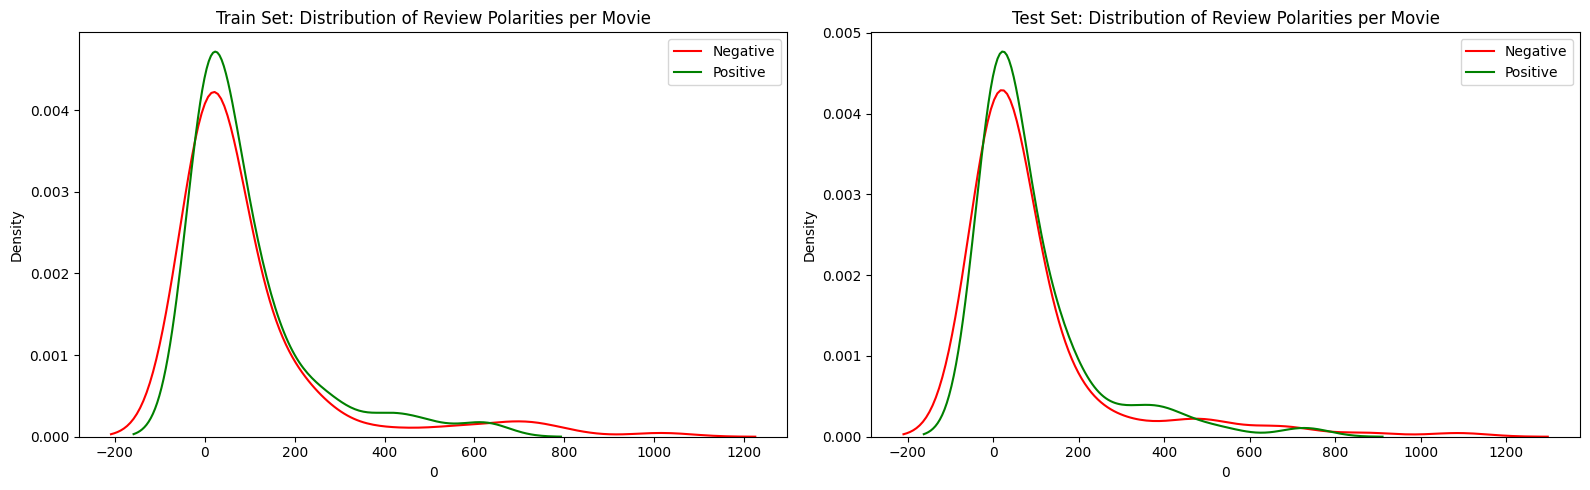

In [14]:
# kde plots for negative/positive rating distributions for train/test sets
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
neg_pos_rev_train = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
neg_pos_rev_train = neg_pos_rev_train.reindex(index=np.arange(neg_pos_rev_train.index.min(), max(neg_pos_rev_train.index.max(), 2021))).fillna(0)
sns.kdeplot(neg_pos_rev_train[0], color='red', label='Negative', ax=ax)
sns.kdeplot(neg_pos_rev_train[1], color='green', label='Positive', ax=ax)
ax.legend()
ax.set_title('Train Set: Distribution of Review Polarities per Movie')

ax2 = axs[1]
neg_pos_rev_test = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
neg_pos_rev_test = neg_pos_rev_test.reindex(index=np.arange(neg_pos_rev_test.index.min(), max(neg_pos_rev_test.index.max(), 2021))).fillna(0)
sns.kdeplot(neg_pos_rev_test[0], color='red', label='Negative', ax=ax2)
sns.kdeplot(neg_pos_rev_test[1], color='green', label='Positive', ax=ax2)
ax2.legend()
ax2.set_title('Test Set: Distribution of Review Polarities per Movie')

fig.tight_layout()

### EDA Conclusions: ###
The Exploratory Data Analysis reveals a few key things about the data and gives some helpful insight before testing:
- The number of movies made per year has increased drastically over the years from the inception of cinema.
- The average amount of review (per 5 years) has increased in a similar trend to movies output over time.
- The amount of reviews per movie ranges with the most common amount being one before tapering off and spiking slightly around 30 reviews.
- The amount of negative and positive reviews is very close to equal.
- The range of reviews from 1-10 show a very simiilar distribution between the train/test datasets with both showing little to no reviews rated from 5-6 and the two most common for both being 1 and 10. This indicates that people rate strongly in either direction (1 being very poor, 10 being excellent) but are very rarely lukewarm in their reception to film neither liking it nor disliking it.
- The distribution of review polarity (positive/negative) is close to equal and very similar from train to test set. With postive having a marginally higher spike than negative but being distributed over fewer values than the negative graph


<div class="alert alert-success"; style="border-left: 7px solid green">
<b>✅ Reviewer's comment V1</b>
    
Good.
</div>

## Evaluation Procedure, Normalisation and Model Training: ##

### Evaluation Procedure: ###

In [15]:
#creating an evaluation procedure for model training (works with typical classifiers and classification models used for interpreting BERT results)
def evaluate_model(model, train_features, train_target, test_features, test_target, tokenizer=None, is_bert=False, device='cuda'):
    eval_stats = {}
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        #F1 Scoring:
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        #ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        #PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        #F1 Score Plotting:
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')

        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds - threshold))
            marker_colour = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_colour, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='upper left')
        ax.set_title('F1 Score')

        #ROC curve Plotting
        ax2 = axs[1]
        ax2.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC: {roc_auc:.2f}')
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds - threshold))
            marker_colour = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_colour, marker='X', markersize=7)
        ax2.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax2.set_xlim([-0.02, 1.02])
        ax2.set_ylim([-0.02, 1.02])
        ax2.set_xlabel('FPR')
        ax2.set_ylabel('TPR')
        ax2.legend(loc='lower center')
        ax2.set_title('ROC Curve')

        #PRC Plotting
        ax3 = axs[2]
        ax3.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds - threshold))
            marker_colour = 'orange' if threshold != 0.5 else 'red'
            ax3.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_colour, marker='X', markersize=7)
        ax3.set_xlim([-0.02, 1.02])
        ax3.set_ylim([-0.02, 1.02])
        ax3.set_xlabel('Recall')
        ax3.set_ylabel('Precision')
        ax3.legend(loc='upper left')
        ax3.set_title('PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

### Normalisation (NLTK and spaCy): ###

In [16]:
#using NLTK
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def lemmatize_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    tokens = word_tokenize(text.lower())
    filtered_tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    lemmas = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    return " ".join(lemmas)

df_reviews['review_norm'] = df_reviews['review'].apply(lemmatize_text)

In [17]:
#using spaCy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def spacy_lemmatize_text(text):
    doc = nlp(text.lower())
    lemmas_spacy = [
        token.lemma_
        for token in doc
        if not token.is_punct
        and not token.like_num
        and token.is_alpha
    ]
    return " ".join(lemmas_spacy)

df_reviews['review_norm_spacy'] = df_reviews['review'].apply(spacy_lemmatize_text)

In [18]:
df_reviews.head(2)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm,review_norm_spacy
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335,pakage implies warren beatty goldie hawn pulli...,the pakage imply that warren beatty and goldie...
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336,hell get made presenting caper comedy misbegot...,how the hell do they get this make present its...


### Normalisation Conclusions: ###
- Opted to normalise and preprocess the text in the 2 most popular ways, NLTK and spaCy, to determine if model performance would be affected at all by either and which would be most beneficial for model training
- spaCy definitely has a much longer runtime but more aggresively lemmatizes the data.
- Wrapped both options into their own function 'lemmatize_text' for NLTK and 'spacy_lemmatize_text' for spaCy.
- Stored the lemmatized text in their own respective columns 'review_norm' and 'review_norm_spacy'

### Train, Test, Split: ###

In [19]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

#NLTK features
train_features = df_reviews_train['review_norm']
test_features = df_reviews_test['review_norm']
#spaCy features
train_features_spacy = df_reviews_train['review_norm_spacy']
test_features_spacy = df_reviews_test['review_norm_spacy']
#targets
train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 19)
(23535, 19)


In [20]:
#vectorizing the text
tfidf_nltk = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9,
    sublinear_tf=True
)
tfidf_spacy = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9,
    sublinear_tf=True
)
#NLTK
train_features_tfidf = tfidf_nltk.fit_transform(train_features)
test_features_tfidf = tfidf_nltk.transform(test_features)
#spaCy
train_features_spacy_tfidf = tfidf_spacy.fit_transform(train_features_spacy)
test_features_spacy_tfidf = tfidf_spacy.transform(test_features_spacy)

<div class="alert alert-danger"; style="border-left: 7px solid red">
<b>⛔️ Reviewer's comment V1</b>
    
I spent a lot of time trying to figure out why you were overfitting significantly, and here is the answer. Should you be using fit on both training and test sets?
</div>

In [21]:
df_reviews_train['pos'].value_counts(normalize=True)
df_reviews_test['pos'].value_counts(normalize=True)

,proportion
pos,
0,0.501508
1,0.498492


### Train, Test, Split and Vectorisation Conclusions: ###
- The data was already split within the original dataframe (ds_part == 'train', ds_part == 'test')
- Vectorised each version of the lemmatized text (NLTK/spaCy) with tfidf vectoriser and used 2 seperate vectorisers respectively
- Created train and test features for both NLTK and spaCy and stored them in their own columns 'train_features_tfidf', 'test_features_tfidf' for NLTK and 'train_features_spacy_tfidf', 'test_features_spacy_tfidf' for spaCy.

### Model Training (NLTK, TF-IDF pre-processing): ###

**Logistic Regression Model (baseline):**

          train  test
Accuracy   0.92  0.88
F1         0.92  0.89
APS        0.97  0.95
ROC AUC    0.97  0.95


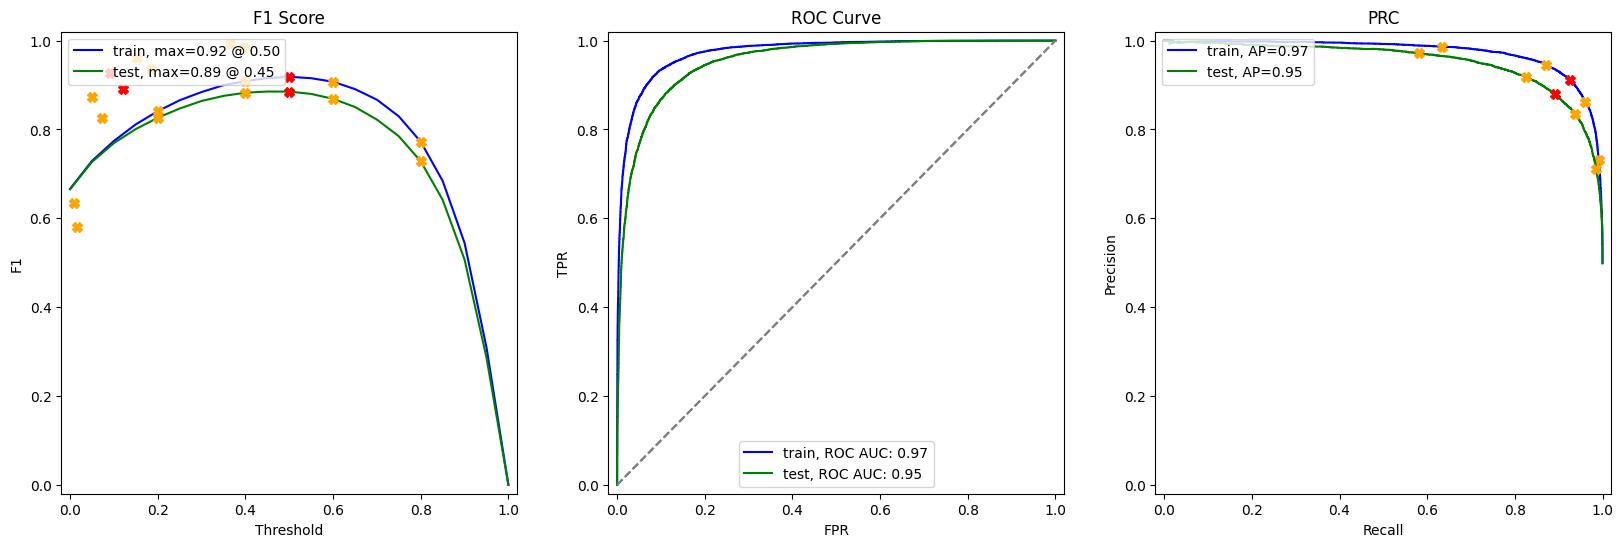

In [22]:
best_lr_model = LogisticRegression(max_iter=2000, class_weight='balanced', C=1.0, solver='liblinear', random_state=246)
best_lr_model.fit(train_features_tfidf, train_target)
evaluate_model(best_lr_model, train_features_tfidf, train_target, test_features_tfidf, test_target)

**RandomForestClassifier:**

          train  test
Accuracy   0.91  0.84
F1         0.91  0.84
APS        0.97  0.92
ROC AUC    0.97  0.92


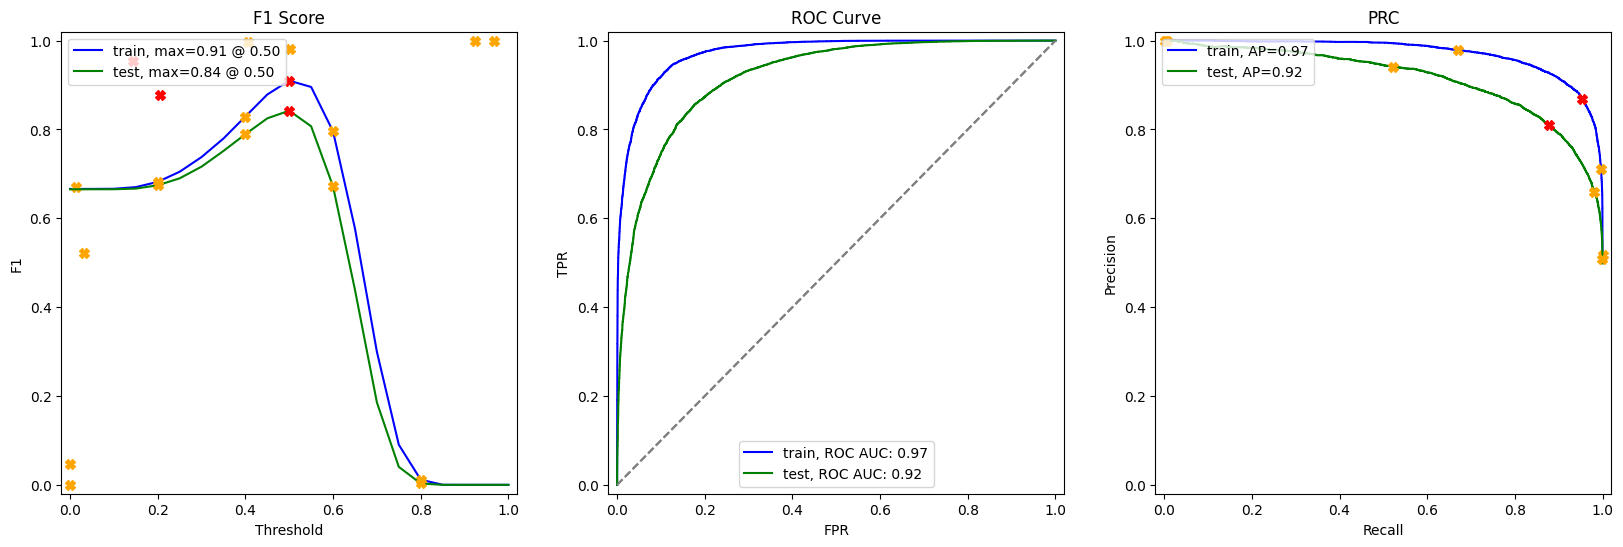

In [23]:
rf_model = RandomForestClassifier(n_estimators=300, max_depth=20, min_samples_leaf=3, min_samples_split=5, class_weight='balanced', n_jobs=-1, random_state=246)
rf_model.fit(train_features_tfidf, train_target)
evaluate_model(rf_model, train_features_tfidf, train_target, test_features_tfidf, test_target)

**LightGBMClassifier:**

[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.441143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 452457
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 4999
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


          train  test
Accuracy   0.96  0.87
F1         0.96  0.87
APS        0.99  0.95
ROC AUC    0.99  0.95


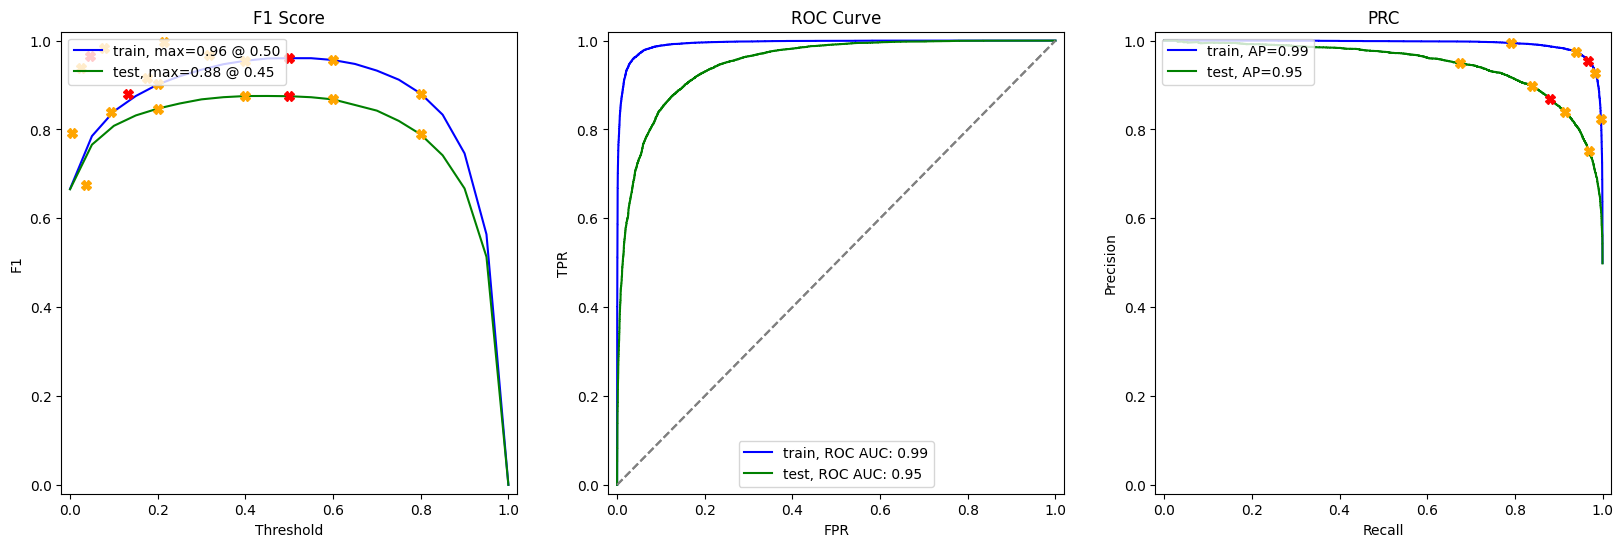

In [24]:
lgbm_model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    random_state=246,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,
    reg_lambda=1.0,
    n_jobs=-1
)
lgbm_model.fit(train_features_tfidf, train_target)
evaluate_model(lgbm_model, train_features_tfidf, train_target, test_features_tfidf, test_target)

### Model Training (spaCy, TF-IDF pre-processing): ###

**Logistic Regression**

          train  test
Accuracy   0.90  0.89
F1         0.91  0.89
APS        0.97  0.95
ROC AUC    0.97  0.96


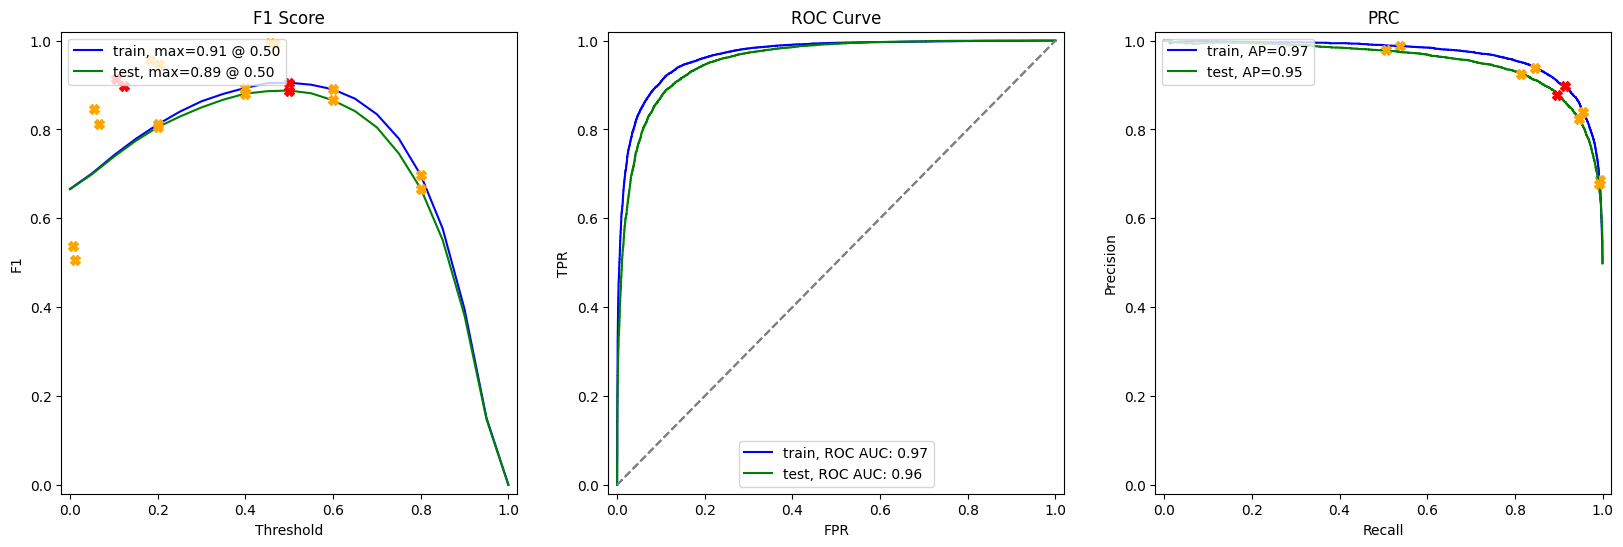

In [25]:
lr_model_spacy = LogisticRegression(max_iter=1000, C=0.5, random_state=246)
lr_model_spacy.fit(train_features_spacy_tfidf, train_target)
evaluate_model(lr_model_spacy, train_features_spacy_tfidf, train_target, test_features_spacy_tfidf, test_target)

**RandomForestClassifier:**

          train  test
Accuracy   0.88  0.82
F1         0.89  0.83
APS        0.96  0.91
ROC AUC    0.96  0.91


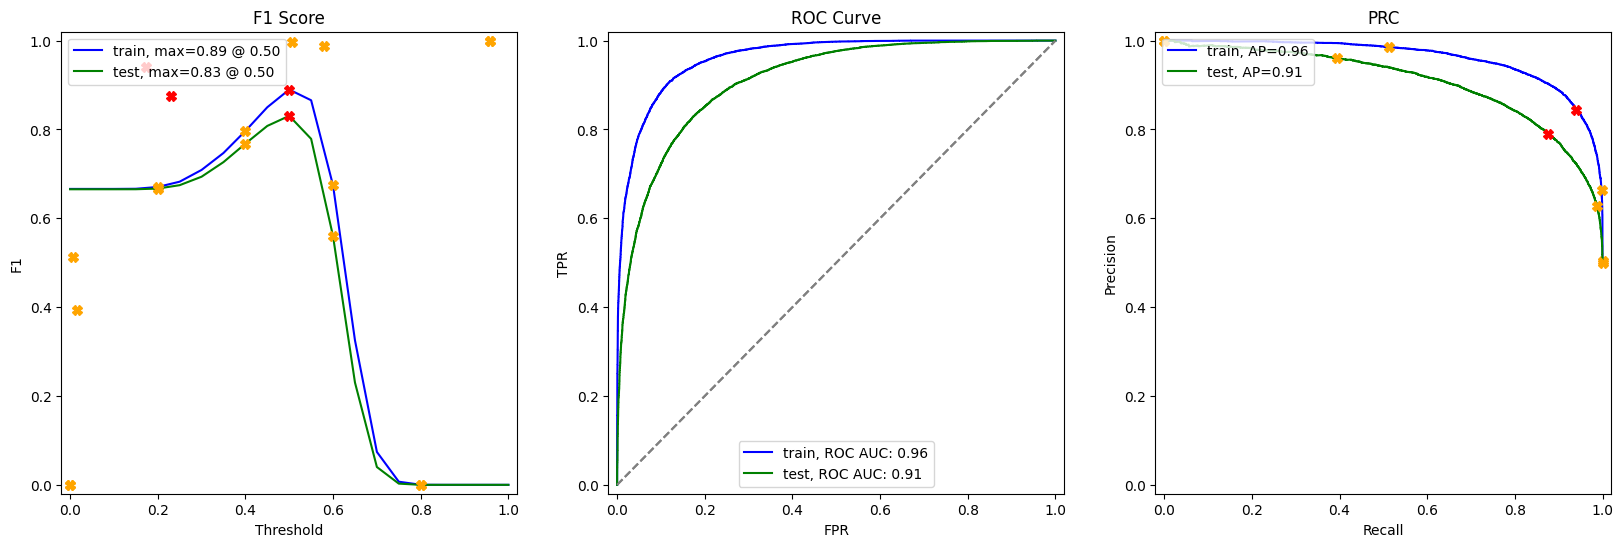

In [26]:
rf_model_spacy = RandomForestClassifier(n_estimators=200, max_depth=12, min_samples_split=3, random_state=246)
rf_model_spacy.fit(train_features_spacy_tfidf, train_target)
evaluate_model(rf_model_spacy, train_features_spacy_tfidf, train_target, test_features_spacy_tfidf, test_target)

[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.497375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 700100
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 5000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


          train  test
Accuracy   0.97  0.88
F1         0.97  0.88
APS        1.00  0.95
ROC AUC    1.00  0.95


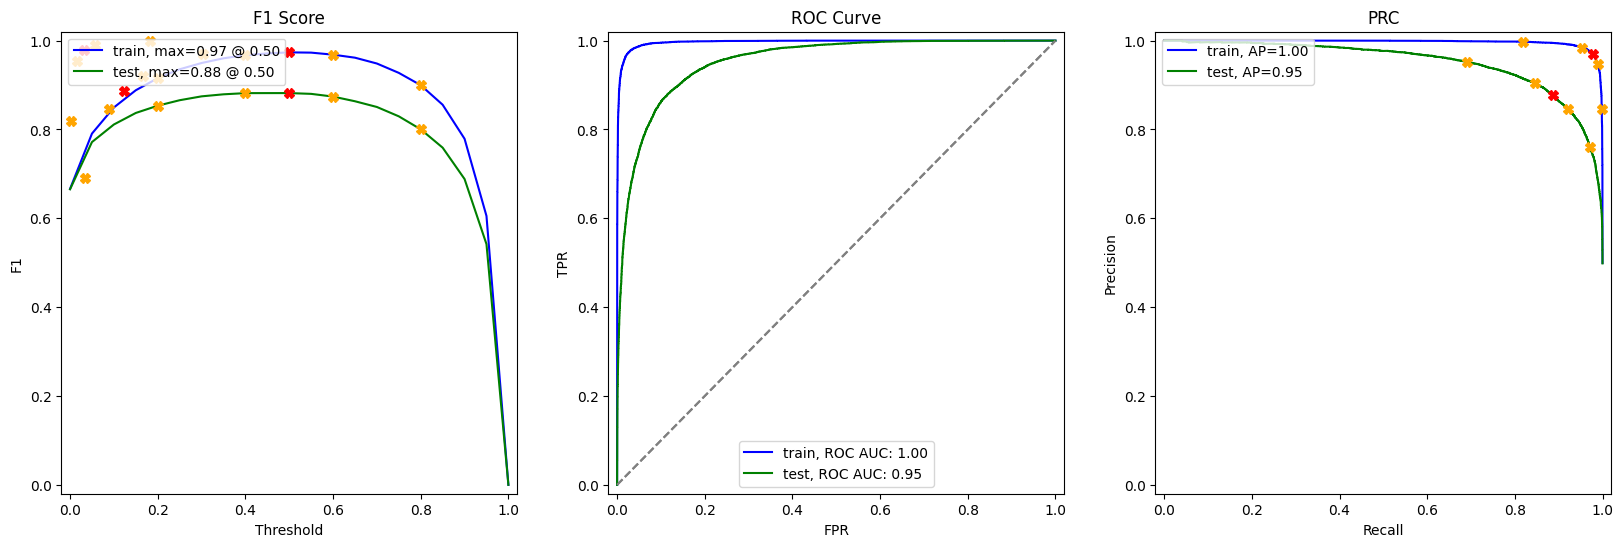

In [27]:
lgbm_model_spacy = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    random_state=246,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,
    reg_lambda=1.0,
    n_jobs=-1
)
lgbm_model_spacy.fit(train_features_spacy_tfidf, train_target)
evaluate_model(lgbm_model_spacy, train_features_spacy_tfidf, train_target, test_features_spacy_tfidf, test_target)

### BERT Models: ###

In [28]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [29]:
def BERT_text_to_embeddings(texts, tokenizer, model, max_length=512, force_device=None, disable_progress_bar=False):

    ids_list = []
    attention_mask_list = []

    batch_size = 500

    for text in texts:
        ids = tokenizer.encode(text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)

        padded = np.array(ids + [0] * (max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)

        ids_list.append(padded)
        attention_mask_list.append(attention_mask)

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)



<div class="alert alert-danger"; style="border-left: 7px solid red">
<b>⛔️ Reviewer's comment V1</b>
    
you have defined max_length in the function header, then you overwrite that a couple of lines into the function. If it is in the fuction header you should not redefine it inside the function.
</div>

In [30]:
bert_train_features = BERT_text_to_embeddings(df_reviews_train['review_norm'], tokenizer, model, force_device='cuda')

Using the cuda device.


  0%|          | 0/48 [00:00<?, ?it/s]

/tmp/ipython-input-2139462405.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)


In [31]:
bert_test_features = BERT_text_to_embeddings(df_reviews_test['review_norm'], tokenizer, model, force_device='cuda')

Using the cuda device.


  0%|          | 0/48 [00:00<?, ?it/s]

In [32]:
scaler = StandardScaler()
bert_train_features_scaled = scaler.fit_transform(bert_train_features)
bert_test_features_scaled = scaler.transform(bert_test_features)

In [33]:
print(df_reviews_train['review_norm'].shape)
print(bert_train_features.shape)
print(train_target.shape)

print(df_reviews_test['review_norm'].shape)
print(bert_test_features.shape)
print(test_target.shape)

(23796,)
(23796, 768)
(23796,)
(23535,)
(23535, 768)
(23535,)


In [34]:
bert_lr = LogisticRegression(max_iter=3000, C=10, random_state=246)
bert_lr.fit(bert_train_features_scaled, train_target)
lr_pred_proba = bert_lr.predict_proba(bert_test_features)[:, 1]

          train  test
Accuracy   0.84  0.82
F1         0.84  0.82
APS        0.92  0.90
ROC AUC    0.92  0.90


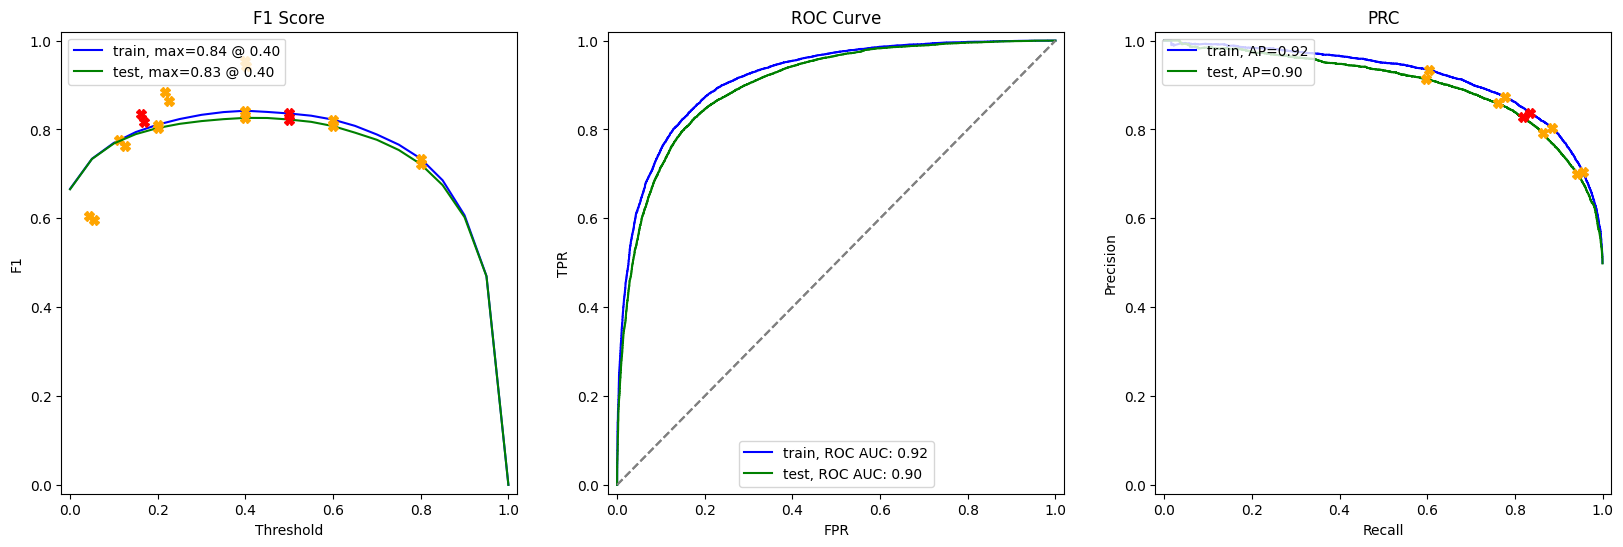

In [35]:
evaluate_model(bert_lr, bert_train_features_scaled, train_target, bert_test_features_scaled, test_target)

In [44]:
bert_lgbm = LGBMClassifier(
    num_leaves=31,
    learning_rate=0.05,
    n_estimators=800,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=246
)
bert_lgbm.fit(bert_train_features, train_target)
pred_proba = bert_lgbm.predict_proba(bert_test_features)[:, 1]

[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.259805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


          train  test
Accuracy    1.0  0.81
F1          1.0  0.81
APS         1.0  0.89
ROC AUC     1.0  0.89


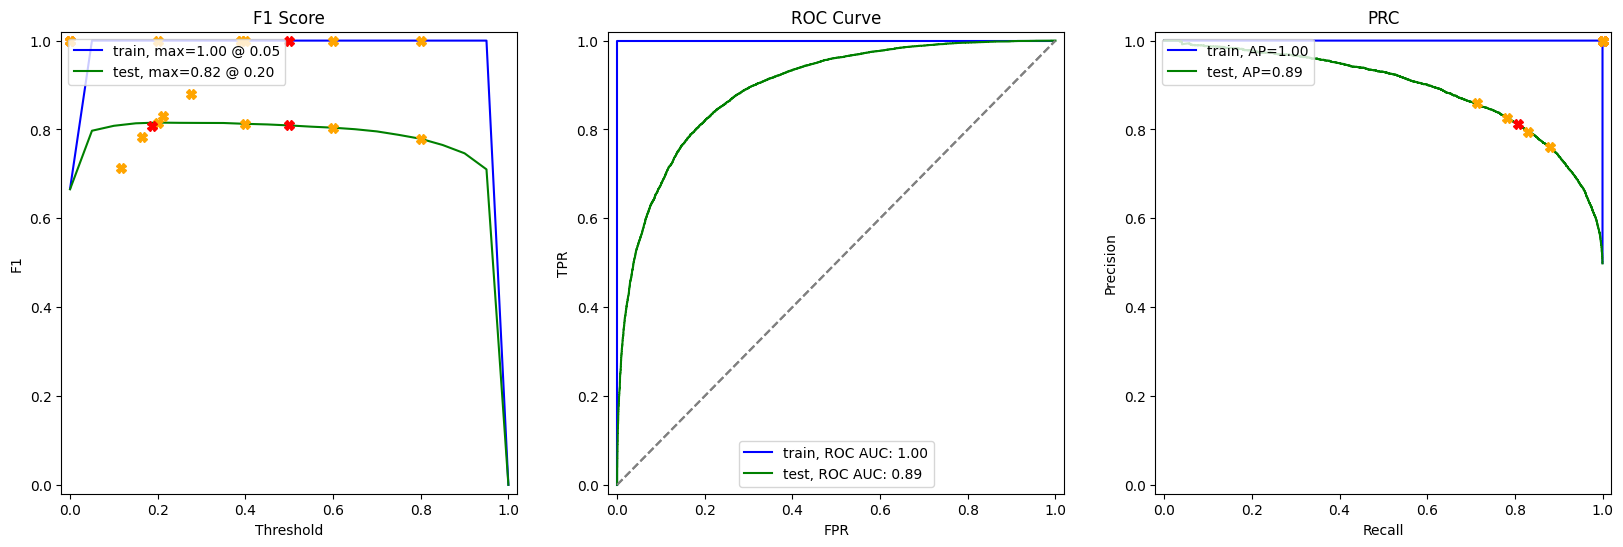

In [37]:
evaluate_model(bert_lgbm, bert_train_features, train_target, bert_test_features, test_target)

<div class="alert alert-danger"; style="border-left: 7px solid red">
<b>⛔️ Reviewer's comment V1</b>
    
This one seems to be overfitting significantly, it is getting 100% accuracy on the training set and only 80 on the test set.
</div>

### Test Set Evaluation: ###

In [46]:
models = {
    "Logistic Regression (NLTK)": best_lr_model,
    "Random Forest (NLTK)": rf_model,
    "LGBM (NLTK)": lgbm_model,
    "Logistic Regression (spaCy)": lr_model_spacy,
    "Random Forest (spaCy)": rf_model_spacy,
    "LGBM (spaCy)": lgbm_model_spacy,
    "BERT Logistic Regression": bert_lr,
    "BERT LGBM": bert_lgbm,
}

def test_models(train_features, test_features, target_train, target_test, label):
    print(f'\n=== {label} Results ===')

    if hasattr(train_features, 'toarray'):
        train_features = train_features.toarray()
    if hasattr(test_features, 'toarray'):
        test_features = test_features.toarray()

    if 'NLTK' in label:
        model_type = 'NLTK'
    elif 'spaCy' in label:
        model_type = 'spaCy'
    elif 'BERT' in label:
        model_type = 'BERT'
    else:
        raise ValueError(f"Unknown label type: {label}")

    filtered_models = {
        name: mmodel
        for name, mmodel in models.items()
        if model_type in name
    }

    for name, mmodel in filtered_models.items():

        pred_test = mmodel.predict(test_features)

        if hasattr(mmodel, 'predict_proba'):
            pred_proba = mmodel.predict_proba(test_features)[:, 1]
        else:
            pred_proba = pred_test


        accuracy = metrics.accuracy_score(test_target, pred_test)
        f1_score = metrics.f1_score(test_target, pred_test)
        roc = metrics.roc_auc_score(test_target, pred_proba)
        print(f'\n{name}:')
        print(f'Accuracy: {accuracy:.2f}')
        print(f'F1 Score: {f1_score:.2f}')
        print(f'ROC-AUC Score: {roc:.2f}')

<div class="alert alert-danger"; style="border-left: 7px solid red">
<b>⛔️ Reviewer's comment V1</b>
    
I ran this on the colab that you linked, it was not able to finish because there is an error here.

![image.png](attachment:5a9c9081-4aaf-4951-ac01-0e00a9280dad.png)

Please ensure you restart the notebook and run all before submission. You need to restart to clear all variables so that you can identify issues like this.

</div>

In [47]:
test_models(train_features_tfidf, test_features_tfidf, train_target, test_target, "NLTK PreProcessing")
test_models(train_features_spacy_tfidf, test_features_spacy_tfidf, train_target, test_target, "spaCy PreProcessing")
test_models(bert_train_features_scaled, bert_test_features_scaled, train_target, test_target, 'BERT Classifiers')


=== NLTK PreProcessing Results ===

Logistic Regression (NLTK):
Accuracy: 0.88
F1 Score: 0.89
ROC-AUC Score: 0.95

Random Forest (NLTK):
Accuracy: 0.84
F1 Score: 0.84
ROC-AUC Score: 0.92


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



LGBM (NLTK):
Accuracy: 0.87
F1 Score: 0.87
ROC-AUC Score: 0.95

=== spaCy PreProcessing Results ===

Logistic Regression (spaCy):
Accuracy: 0.89
F1 Score: 0.89
ROC-AUC Score: 0.96

Random Forest (spaCy):
Accuracy: 0.82
F1 Score: 0.83
ROC-AUC Score: 0.91


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



LGBM (spaCy):
Accuracy: 0.88
F1 Score: 0.88
ROC-AUC Score: 0.95

=== BERT Classifiers Results ===

BERT Logistic Regression:
Accuracy: 0.82
F1 Score: 0.82
ROC-AUC Score: 0.90


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



BERT LGBM:
Accuracy: 0.77
F1 Score: 0.79
ROC-AUC Score: 0.86


### BERT Fine Tuned Final Testing: ###

### Model Training and Testing Conclusions: ###
Trained a wide variety of models to determine the best approach, started off with regular classifiers, LogisticRegression and RandomForestClassifier before trying a gradient boosting model LGBM. Then trained a fixed BERT model that can't classify on its own and needs assistance from other classifiers (Here Logistic Regression and LGBM), finally trained a BERT model that can classify results automatically and does not need to have the features extracted with an external classifier.

Evaluated all models with the exception of the fine tuned BERT model with the evaluate model function, which produces graphs for F1, PRC (Precision Recall Curve), ROC-AUC (Receiver Operating Characteristic Area Under Curve) as well as produce predictions of the trained model on the test set

**Logistic Regression (NLTK/spaCy)**

- Used this model as a baseline as it is simple and requires little hyperparater tuning.
- Performed well on training set with f1 score being aroung 0.9 for both, and they performed very well on the test set with the NLTK model scoring 0.88 and the spaCy model scoring around 0.89 well above the threshold
- This indicates minimal overfitting and although all company requirements are met will need to perform further testing to determine if this is the optimal model.

**RandomForestClassifier (NLTK/spaCy)**

- Again performed well on the training set but marginally worse for both when compared to the test data.
- This model does not have serious evidence of overfitting between training and testing and the NLTK model scored a final F1 around 0.84 and the spaCy model around 0.83 so fairly accurate all things considered.
- However the slow runtime and the fact that it falls below the threshold can rule the model out in the final recommendation.

**LightGBMClassifier (NLTK/spaCy)**

- These models scored the second best across both styles of vectorisation with final F1 score of 0.87 (NLTK) and 0.88 (spaCy) respectively
- Marginally less accurate and a fair amount slower than the Logistic Regression model which has performed the best thus far.
- Can likely rule this model out in the final analysis due to the slightly less accurate but definitely slower runtime, but will train a few BERT based models (specifically for Natural Language Representation) to determine if the Logistic Regression model is still the best option.

**BERT (Logistic Regression/LGBM)**

- Created a fixed BERT model that was pretrained on lowercase English texts and used BERT_text_to_embeddings function to extract the embeddings for BERT, this is a drastically slower process as the BERT model takes much longer to craft embeddings than using a vectoriser in conjunction with NLTK, spaCy formatting.
- This format works well but need to use an external classifier (LogisticRegression/LGBM) to extract features and gain predictions
- Both scored well with a final F1 score around 0.80-0.82 the Logistic Regression model showed little evidence of overfitting but the LGBM model shows some serious signs of overfitting with the model scoring perfectly on the training data but only around 0.80 F1 when compared against the test set.
- This is a great method however it scored worse overall than the Logistic Regression model trained on both NLTK and spaCy. The long compusational time (>20 minutes) means that although it is more accurate instantly the failure to outperform the Logistic Regression model means that it can't be recommended in the final analysis.


### Classifying Reviews: ###

In [48]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(lemmatize_text)
my_reviews['review_norm_spacy'] = my_reviews['review'].apply(spacy_lemmatize_text)
my_reviews.head()

,review,review_norm,review_norm_spacy
0,"I did not simply like it, not my kind of movie.",simply like kind movie,I do not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well bored felt asleep middle movie,well I be bored and feel asleep in the middle ...
2,I was really fascinated with the movie,really fascinated movie,I be really fascinate with the movie
3,Even the actors looked really old and disinter...,even actor looked really old disinterested got...,even the actor look really old and disinterest...
4,I didn't expect the reboot to be so good! Writ...,didnt expect reboot good writer really cared s...,I do expect the reboot to be so good writer re...


In [49]:
nltk_texts = my_reviews['review_norm']
spacy_texts = my_reviews['review_norm_spacy']
bert_features = BERT_text_to_embeddings(my_reviews['review'], tokenizer, model, force_device='cuda', disable_progress_bar=True)

In [50]:
for name, model3 in models.items():

    print(f'\n ===Predictions for {name} ===')

    if 'NLTK' in name:
        X = tfidf_nltk.transform(nltk_texts)
        probs = model3.predict_proba(X)[:, 1]
    elif 'spaCy' in name:
        X = tfidf_spacy.transform(spacy_texts)
        probs = model3.predict_proba(X)[:, 1]
    elif name in ['BERT Logistic Regression', 'BERT LGBM']:
        probs = model3.predict_proba(bert_features)[:, 1]
    else:
        raise ValueError(f"Unknown model type: {name}")

    for prob, review in zip(probs, my_reviews['review']):
        sentiment = "Positive" if prob > 0.5 else 'Negative'
        print(f'{prob:.2f}: {review}')


 ===Predictions for Logistic Regression (NLTK) ===
0.21: I did not simply like it, not my kind of movie.
0.15: Well, I was bored and felt asleep in the middle of the movie.
0.36: I was really fascinated with the movie
0.08: Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.
0.17: I didn't expect the reboot to be so good! Writers really cared about the source material
0.41: The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see myself going to see it again.
0.05: What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won't like this!
0.95: Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.

 ===Predictions for Random Forest (NLTK) ===
0.57: I did not simply like it, not my kind of movie.
0.59: Well, I was bored and felt asleep in the mid

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### My Reviews Conclusions: ###
- Tested each respective model on a small handful of reviews to see if they can classify positive and negative reviews on an individual scale.
- The regular classifiers performed well with the Logistic Regression doing the best out of the three.
-  The BERT based models performed well but as discussed in the testing stage they failed to outperform the Logistic Regression/LGBM models trained with NLTK/spaCy processed data and did marginally worse on an individual review basis as well as the final F1 score.

## Final Conclusions: ##
Out of all the models tested the Logistic Regression model trained on the spaCy preprocessed text performed the best with a final F1 score of 0.89 and accurate predictions at an individual level. This is what would be best for Film Junky Union review classification system.

The model:

- Performs the best in terms of F1 score and exceeds the company threshold of 0.85
- The model does not overfit from the training set to the test set.
- Performs very well on an individual level and can classify reviews accurately and according to the tonality and language used by the reviewer.
- Is very fast computationally and does not require a powerful GPU to run of all the models tested it is by far the most time efficient in addition to the accuracy of the model.